# 설정

In [24]:
# 파이썬 ≥ 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥ 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Logistic Regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

결정 경계를 그려주는 함수

In [25]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # 마커와 컬러맵을 설정한다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계를 그린다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
        
    # 테스트 샘플을 부각하여 그린다
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    facecolors='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

다음 코드는 iris 데이터셋을 불러들이고 학습셋과 테스트셋으로 나눈 후 표준화를 하는 과정이다.

In [26]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 로지스틱 회귀를 사용한 클래스 확률 모델링

<b>로지스틱 회귀</b><sup>logistic regression</sup>(또는 <b>로짓 회귀</b><sup>logit regression</sup>)는 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용된다(예를 들면 이 이메일이 스팸일 확률은 얼마인가?). 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측한다(즉, 레이블이 '1'인 <b>양성 클래스</b><sup>positive class</sup>). 아니면 클래스에 속하지 않는다고 예측한다(즉, 레이블이 '0'인 <b>음성 클래스</b><sup>negative class</sup>). 이를 이진 분류기라고 한다.

로지스틱 회귀와 퍼셉트론의 차이로는 활성화 함수가 <b>시그모이드 함수</b><sup>sigmoid function</sup>(혹은 <b>로지스틱 시그모이드 함수</b><sup>logistic sigmoid function</sup>)라는 점, 손실 함수가 <b>교차 엔트로피 오차 함수</b><sup>cross-entropy error function</sup>인 점, <b>규제항</b><sup>regularization term</sup>이 추가되어서 과적합을 방지할 수 있다는 점, 온라인 학습과 배치 학습에 모두 적용할 수 있다는 점 등을 볼 수 있다.

로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어나다. 이 때문에 로지스틱 회귀를 이진 분류의 기본 모델로 사용하는 경우가 많다. 또한 로지스틱 회귀는 희소한 데이터 세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에서도 자주 사용된다.

정리하자면 로지스틱 회귀는 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 것이다.

## 로지스틱 회귀의 이해와 조건부 확률

로지스틱 회귀는 구현하기 매우 쉽고 선형적으로 구분되는 클래스에 뛰어난 성능을 내는 분류 모델이다. 산업계에서 가장 널리 사용되는 분류 알고리즘 중 하나다. 퍼셉트론이나 아달린과 마찬가지로 로지스틱 회귀 모델도 이진 분류를 위한 선형 모델이지만 다중 분류로 확장할 수 있다. 예를 들어 OvR 방식을 사용한다.

확률 모델로서 로지스틱 회귀 모델 이면에 있는 아이디어를 설명하기 위해 먼저 <b>오즈비</b><sup>odds ratio</sup>를 소개한다. 오즈(승산이라고도 한다)는 특정 이벤트가 발생할 확률이다. 오즈비는 성공 확률이 실패 확률에 비해 몇 배 더 높은가를 나타낸다. 여기서 <i>P</i>는 양성 샘플일 확률이다. 양성 샘플은 좋은 것을 의미하지 않고 예측하려는 대상을 말한다. 예를 들어 환자가 어떤 질병을 가지고 있을 확률이다. 양성 샘플이 클래스 레이블 y=1인 샘플이다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/odds ratio.png">
</div>

오즈비를 그래프로 그리면 다음과 같다. <i>P</i>가 0부터 1까지 증가할 때 오즈비의 값은 처음에는 천천히 증가하지만 <i>P</i>가 1에 가까워지면 급격히 증가한다.

<b>그림 1</b> 오즈비 그래프
<div style="text-align:center;">
    <img src="./images/Logistic Regression/오즈비 그래프.png">
</div>

오즈비에 로그 함수를 취해 로짓<sup>logit</sup> 함수를 정의한다. 여기서 <i>log</i>는 컴퓨터 과학에서 널리 사용되는 자연 로그다. <i>logit</i> 함수는 [0, 1] 범위의 입력(확률이므로)을 받아 (－∞, ＋∞)의 범위 값으로 변환한다. 

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/logit 함수.png">
</div>

로짓 함수는 <i>P</i>가 0.5일 때 0이 되고 <i>P</i>가 0과 1일 때 각각 무한대로 음수와 양수가 되는 특징을 갖는다. 다음은 로짓 함수의 그래프다.

<b>그림 2</b> 로짓 함수 그래프
<div style="text-align:center;">
    <img src="./images/Logistic Regression/로짓함수 그래프.png">
</div>

특성의 가중치 합과 로그 오즈 사이의 선형 관계를 다음과 같이 쓸 수 있다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/가중합과 로그 오즈 사이의 관계.png">
</div>

여기서 <i>p</i>(<i>y</i>=1|<b>x</b>)는 특성 <b>x</b>가 주어졌을 때 이 샘플이 클래스 1에 속할 조건부 확률이다.

어떤 샘플이 특정 클래스에 속할 <b>확률</b>을 예측하는 것이 관심 대상이므로 <i>logit</i> 함수를 거꾸로 뒤집는다. 이 함수를 로지스틱 시그모이드 함수라고 한다. 함수 모양이 S자 형태를 띠기 때문에 간단하게 줄여서 시그모이드 함수라고도 한다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/sigmoid.png">
</div>

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 로짓과 로지스틱 함수는 서로 역함수 관계이다. 그래서 로지스틱 함수의 입력을 로짓이라고 부른다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/유도과정.png">
    </div><br>
    로짓을 <b>로그 오즈</b><sup>log-odds</sup>라고도 부른다. 로그 오즈는 양성 클래스 추정 확률과 음성 클래스 추정 확률 사이의 로그 비율이기 때문이다.
</div>

여기서 z는 가중치와 샘플 특성의 선형 조합으로 이루어진 최종 입력이다. 즉, z = <b>w</b><sup>T</sup><b>x</b> = <i>w</i><sub>0</sub><i>x</i><sub>0</sub> + <i>w</i><sub>1</sub><i>x</i><sub>1</sub> + ... + <i>w</i><sub>m</sub><i>x</i><sub>m</sub> 이다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> Perceptron에서 사용했던 방식처럼 <i>w</i><sub>0</sub>은 절편을 의미한다. 이를 위해 값이 1인 입력 <i>x</i><sub>0</sub>를 추가한다.
</div>

## 시그모이드 함수

시그모이드는 다음과 같은 S자 형태의 함수이다. 계단 함수와 같이 함숫값의 범위도 [0, 1] 사이이다. 시그모이드 함수는 모든 구간에서 미분할 수 있고 증가 함수이므로 미분값이 항상 양수이다(이를 단조 증가라고 한다).

시그모이드 함수<sup><a id="a01" href="#p01">[1]</a></sup>가 어떤 모습인지 -7에서 7까지 그려 보겠다.

그림 저장: 시그모이드 곡선


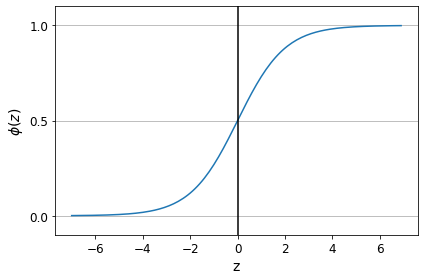

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y축의 눈금과 격자선
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
save_fig('시그모이드 곡선')
plt.show()

z가 무한대로 가면(z→∞) <i>e<sup>-z</sup></i>가 매우 작아지기 때문에 <i>Φ(z)</i>는 1에 가까워진다. 비슷하게 z→－∞이면 점점 분모가 커지기 때문에 <i>Φ(z)</i>는 0에 수렴한다. 이 시그모이드 함수는 실수 입력 값을 [0, 1] 사이의 값으로 변환한다. 중간은 <i>Φ(0)</i> = 0.5다.

시그모이드는 오랫동안 활성 함수로 사용되었지만 다음과 같은 몇 가지 문제점이 있다.
<ul>
    <li>함수 정의에 지수 함수가 포함되어 있어서 연산 비용이 많이 든다.</li>
    <li>그레디언트 포화가 발생해서 학습이 중단될 수 있다.</li>
    <li>양수만 출력하므로 학습 경로가 진동하면서 학습 속도가 느려진다.</li>
</ul>

<b>그레디언트 포화</b><sup>gradient saturation</sup>란 시그모이드 함수 끝부분에서 미분값이 0으로 포화되는 상태를 말한다. 함수에서 <b>포화</b><sup>saturation</sup>란 입력값이 변화해도 함수값이 변화하지 않는 상태를 말한다. 다음 그림에서 시그모이드 함수는 주황색 곡선으로 그려저 있고 도함수는 파란색 곡선으로 그려져 있다. 시그모이드 함수는 양쪽 끝에서 함수값이 0과 1로 포화하기 때문에 <b>미분값</b>도 0으로 포화한다. 그레디언트가 0으로 포화하면 그레디언트 소실로 학습이 진행되지 않는다.

<div style="text-align:center;">
    <img src="./images/Logistic Regression/시그모이드 함수의 그레디언트 포화.png">
</div>

한편 시그모이드의 출력은 항상 양수이기 때문에 학습 시 최적화 경로가 최적해를 향해 곧바로 가지 못하고 좌우로 진동하면서 비효율적으로 가게 된다.

### 시그모이드 함수와 계단 함수 비교

시그모이드 함수와 Perceptron의 활성화 함수인 계단 함수를 비교해보자. 이 두 함수를 [그림 3]에 함께 그려봤다.

<b>그림 3</b> 계단 함수(점선)와 시그모이드 함수(실선)
<div style="text-align:center;">
    <img src="./images/Logistic Regression/계단 함수와 시그모이드 함수.png">
</div>

[그림 3]을 보고 가장 먼저 느껴지는 점은 '매끄러움'의 차이일 것이다. 시그모이드 함수는 부드러운 곡선이며 입력에 따라 출력이 연속적으로 변화한다. 한편, 계단 함수는 0을 경계로 출력이 갑자기 바뀌어버린다. 시그모이드 함수의 이 매끈함이 신경망 학습에서 아주 중요한 역할을 하게 된다(미분이 가능하기 때문에).

계단 함수가 0과 1 중 하나의 값만 돌려주는 반면 시그모이드 함수는 실수를 돌려준다는 점도 다르다. 다시 말해 퍼셉트론에서는 뉴런 사이에 0 혹은 1이 흘렀다면, 신경망에서는 연속적인 실수가 흐른다.

두 함수는 매끄러움이라는 점에서는 다르지만, [그림 3]을 큰 관점에서 보면 둘은 같은 모양을 하고 있다. 둘 다 입력이 작을 때의 출력은 0에 가깝고(혹은 0이고), 입력이 커지면 출력이 1에 가까워지는(혹은 1이 되는) 구조인 것이다. 즉, 계단 함수와 시그모이드 함수는 입력이 중요하면 큰 값을 출력하고 입력이 중요하지 않으면 작은 값을 출력한다. 그리고 입력이 아무리 작거나 커도 출력은 0에서 1 사이라는 것도 둘의 공통점이다.

### 비선형 함수

계단 함수와 시그모이드 함수의 공통점은 그 밖에도 있다. 중요한 공통점으로, 둘 모두 <b>비선형 함수</b>다. 시그모이드 함수는 곡선, 계단 함수는 계단처럼 구부러진 직선으로 나타나며, 동시에 비선형 함수로 분류된다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 활성화 함수를 설명할 때 비선형 함수와 선형 함수라는 용어가 자주 등장한다. 함수란 어떤 값을 입력하면 그에 따른 값을 돌려주는 '변환기'다. 이 변환기에 무언가 입력했을 때 출력이 입력의 상수배만큼 변하는 함수를 <b>선형 함수</b>라고 한다. 수식으로는 <i>f(x) = ax + b</i>이고, 이때 <i>a</i>와 <i>b</i>는 상수다. 그래서 선형 함수는 곧은 1개의 직선이 된다. 한편, <b>비선형 함수</b>는 문자 그대로 '선형이 아닌' 함수다. 즉, 직선 1개로는 그릴 수 없는 함수를 말한다.
</div>

신경망에서는 활성화 함수로 비선형 함수를 사용해야 한다. 달리 말하면 선형 함수를 사용해서는 안 된다. 그 이유는 바로 선형 함수를 이용하면 신경망의 층을 깊게 하는 의미가 없어지기 때문이다.

선형 함수의 문제는 층을 아무리 깊게 해도 '은닉층이 없는 네트워크'로도 똑같은 기능을 할 수 있다는 데 있다. 구체적으로 (약간 직감적으로) 설명해주는 간단한 예를 생각해보자. 선형 함수인 <i>h(x) = cx</i>를 활성화 함수로 사용한 3층 네트워크를 떠올려보자. 이를 식으로 나타내면 <i>y(x) = h(h(h(x)))</i>가 된다. 이 계산은 <i>y(x) = c * c * c * x</i>처럼 곱셈을 세 번 수행하지만, 실은 <i>y(x) = ax</i>와 똑같은 식이다. <i>a = c<sup>3</sup></i>이라고만 하면 끝이다. 즉, 은닉층이 없는 네트워크로도 표현할 수 있다. 이 예처럼 선형 함수를 이용해서는 여러 층으로 구성하는 이점을 살릴 수 없다. 그래서 층을 쌓는 혜택을 얻고 싶다면 활성화 함수로는 반드시 비선형 함수를 사용해야 한다.

## 아달린과 로지스틱 회귀의 차이점

로지스틱 회귀 모델을 직관적으로 이해하기 위해 아달린과 연관 지어 생각해보자. 아달린에서는 활성화 함수로 항등 함수 <i>Φ(z) = z</i>를 사용했다. 로지스틱 회귀에서는 앞서 정의한 시그모이드 함수가 활성화 함수가 된다. 아달린과 로지스틱 회귀의 차이점을 [그림 4]에 나타냈다.

<b>그림 4</b> 아달린과 로지스틱 회귀의 차이점
<div style="text-align:center;">
    <img src="./images/Logistic Regression/아달린과 로지스틱 회귀의 차이점.jpg">
</div>

가중치 <b>w</b>와 곱해지는 특성 <b>x</b>에 대한 시그모이드 함수의 출력을 특정 샘플이 클래스 1에 속할 확률 <i>Φ(z) = P(y=1</i> |<b>x;w</b>)로 해석한다. 예를 들어 어떤 붓꽃 샘플이 <i>Φ(z)</i> = 0.8이라면 이 샘플은 Iris-versicolor일 확률이 80%란 뜻이다. 이 샘플이 Iris-setosa일 확률은 <i>P(y=0</i> |<b>x;w</b>) = 1 - P(y=1</i> |<b>x;w</b>) = 0.2처럼 계산되어 20%가 된다. 예측 확률은 임계 함수를 사용하여 간단하게 이진 출력으로 바꿀 수 있다. 그리고 이 문턱값(0.5)을 하이퍼파라미터로 간주하여 원하는 성능에 따라 조절하는 경우도 있다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/로지스틱 회귀 임계 함수.png">
</div>

앞의 시그모이드 함수 그래프를 보면 다음과 동일하다는 것을 알 수 있다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/로지스틱 회귀 임계 함수2.png">
</div>

실제로 클래스 레이블을 예측하는 것 외에 클래스에 소속될 확률(임계 함수를 적용하기 전 시그모이드 함수 출력)을 추정하는 것이 유용한 애플리케이션도 많다. 예를 들어 어떤 날에 비가 오는지 예측하는 것뿐만 아니라 비 올 확률을 예측해야 하는 날씨 예보에 로지스틱 회귀를 사용할 수 있다. 비슷하게 어떤 증상이 있는 환자가 특정 질병을 가질 확률을 예측하는 데 로지스틱 회귀를 사용할 수 있다. 이것이 로지스틱 회귀가 의학 분야에 널리 사용되는 이유다.

## 로지스틱 회귀 중간 정리하기

로지스틱 회귀는 이진 분류가 목표이므로 －∞부터 ＋∞의 범위를 갖는 <i>z</i>(가중합)의 값을 조절할 방법이 필요했다. 그래서 시그모이드 함수를 활성화 함수로 사용한 것이다. 이는 시그모이드 함수를 통과하면 <i>z</i>를 확률처럼 해석할 수 있기 때문이다. 그리고 시그모이드 함수의 확률인 <i>Φ(z)</i>를 0과 1로 구분하기 위하여 마지막에 임계 함수를 사용했다. 그 결과 입력 데이터(<i>x</i>)는 0 또는 1의 값으로 나누어졌다. 즉, 이진 분류가 되었다.

드디어 로지스틱 회귀가 '이진 분류를 하기 위한 알고리즘'인 진짜 이유를 알았다. 그런데 아직 우리는 가중치와 절편을 적절하게 업데이트할 수 있는 방법을 배우지 않았다. 그렇다면 로지스틱 회귀에는 어떤 손실 함수를 사용해야 할까? 아달린에서 손실 함수로 제곱 오차합을 사용했듯이 분류 문제에서도 제곱 오차합을 사용할 수 있을까? 이제 로지스틱 회귀를 위한 손실 함수인 로지스틱 손실 함수에 대해 알아보자.

## 로지스틱 비용 함수의 가중치 학습

로지스틱 회귀 모델이 확률과 클레스 레이블을 어떻게 예측했는지 배웠다. 이제 모델 파라미터 <b>w</b>를 어떻게 학습하는지 간단하게 살펴보겠다. 아달린에서 다음과 같은 제곱 오차합 비용 함수를 정의했다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/Adaline_cost_func.png">
</div>

아달린 분류 모델에서 이 함수를 최소화하는 가중치 <i>w</i>를 학습한다. 그러면 로지스틱 회귀 모델은 어떻게 훈련을 시킬까? <u>훈련의 목적은 양성 샘플(y=1)에 대해서는 높은 확률로 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 가중치를 찾는 것이다.</u>

로지스틱 회귀의 비용 함수를 유도하는 방법을 설명하기 위해 먼저 로지스틱 회귀 모델을 만들 때 최대화하려는 가능도<sup>likelihood</sup> <i>L</i>을 정의하겠다. 데이터셋에 있는 각 샘플이 서로 독립적이라고 가정한다. 공식은 다음과 같다.<sup><a id="a02" href="#p02">[2]</a></sup>

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/가능도.png">
</div>

실전에서는 이 공식의 (자연) 로그를 최대화하는 것이 더 쉽다. 이 함수를 로그 가능도 함수라고 한다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/로그 가능도 함수.png">
</div>

첫째, 로그 함수를 적용하면 가능도가 매우 작을 때 일어나는 수치상의 언더플로<sup>underflow</sup>를 미연에 방지한다. 둘째, 계수의 곱을 계수의 합으로 바꿀 수 있다. 이렇게 하면 도함수를 구하기 쉽다.

경사 상승법 같은 최적화 알고리즘을 사용하여 이 로그 가능도 함수를 최대화할 수 있다. 또는 로그 가능도 함수를 다시 비용 함수 <i>J</i>로 표현하여 아달린에서처럼 경사 하강법을 사용하여 최소화할 수 있다. 이를 <b>교차 엔트로피 오차</b><sup>cross entropy error, CEE</sup>라고도 한다.

<div style="text-align:center;">
    <img src='./images/formula/Logistic Regression/비용함수 J.png'>
</div>

안타깝게도 이 비용 함수의 최솟값을 계산하는 알려진 해가 없다(정규방정식 같은 것이 없다). 하지만 이 비용 함수는 볼록 함수이므로 경사 하강법(또는 어떤 다른 최적화 알고리즘)이 전역 최솟값을 찾는 것을 보장한다(학습률이 너무 크지 않고 충분히 기다릴 시간이 있다면).

이 비용 함수를 더 잘 이해하기 위해 샘플이 하나일 때 비용을 계산해 보자.

<div style="text-align:center;">
    <img src='./images/formula/Logistic Regression/비용함수 예시.png'>
</div>

식을 보면 y=0일 때 첫 번째 항이 0이 된다. y=1일 때는 두 번째 항이 0이 된다.

<div style="text-align:center;">
    <img src='./images/formula/Logistic Regression/비용함수 예시 2.png'>
</div>

간단한 코드로 샘플이 하나인 경우 <i>Φ(z)</i> 값에 대한 분류 비용을 그려 보겠다.

그림 저장: 시그모이드 활성화 대비 로지스틱 비용 그래프


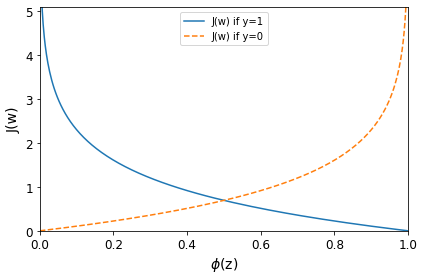

In [30]:
def cost_1(z):
    return -np.log(sigmoid(z))
def cost_0(z):
    return -np.log(1 - sigmoid(z))
z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
save_fig('시그모이드 활성화 대비 로지스틱 비용 그래프')
plt.show()

결과 그래프의 x축은 0에서 1까지 범위의 시그모이드 활성화 값이다(시그모이드 함수의 입력인 <i>z</i>는 -10에서 10까지 범위다). y축은 해당하는 로지스틱 비용이다.

클래스 1에 속한 샘플을 정확히 예측하면 비용이 0에 가까워지는 것을 볼 수 있다(실선). 비슷하게 클래스 0에 속한 샘플을 y=0으로 정확히 예측하면 y축의 비용이 0에 가까워진다(점선). 예측이 잘못되면 비용이 무한대가 된다. 잘못된 예측에 점점 더 큰 비용을 부여한다는 점이 중요하다.

## 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

로지스틱 회귀를 구현하려면 아달린 구현에서 비용 함수 J를 새로운 비용 함수로 바꾸기만 하면 된다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/비용함수.png">
</div>

이 함수로 에포크마다 모든 훈련 샘플을 분류하는 비용을 계산한다. 선형 활성화 함수를 시그모이드 활성화로 바꾸고 임계 함수가 클래스 레이블 -1과 1이 아니고 0과 1을 반환하도록 변경한다. 아달린 코드에 이 세 가지를 반영하면 로지스틱 회귀 모델을 얻을 수 있다. 결과 코드는 다음과 같다.

In [48]:
class LogisticRegressionGD(object):
    """경사 하강법을 사용한 로지스틱 회귀 분류기

    매개변수
    ------------
    eta : float
      학습률 (0.0과 1.0 사이)
    n_iter : int
      훈련 데이터셋 반복 횟수
    random_state : int
      가중치 무작위 초기화를 위한 난수 생성기 시드

    속성
    -----------
    w_ : 1d-array
      학습된 가중치
    cost_ : list
      에포크마다 누적된 로지스틱 비용 함수 값

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """훈련 데이터 학습

        매개변수
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          n_samples 개의 샘플과 n_features 개의 특성으로 이루어진 훈련 데이터
        y : array-like, shape = [n_samples]
          타깃값

        반환값
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 오차 제곱합 대신 로지스틱 비용을 계산합니다.
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """로지스틱 시그모이드 활성화 계산"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """단위 계단 함수를 사용하여 클래스 레이블을 반환합니다"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 다음과 동일합니다.
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

여기서 직접 구현한 로지스틱 모델은 이진 분류 문제에만 적용할 수 있다. Iris-setosa와 Iris-versicolor 붓꽃만 가지고 (클래스 0과 클래스 1) 로지스틱 회귀 구현이 작동하는지 확인해보자.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_46168\187253513.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


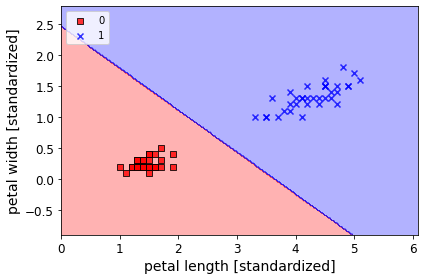

In [49]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> <b>로지스틱 회귀를 위한 경사 하강법 알고리즘</b><br><br>
    미적분을 사용하면 경사 하강법을 사용한 로지스틱 회귀의 가중치 업데이트가 아달린에서 사용한 식과 같다는 것을 보일 수 있다.<br><br>
    먼저 <i>j</i> 번째 가중치에 대한 로그 가능도 함수의 편도 함수를 계산해 보자.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/로그 가능도 함수의 편도 함수.png">
    </div><br>
    계속하기 전에 시그모이드 함수의 편도 함수를 계산해 보겠다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/시그모이드 함수의 편도 함수.png">
    </div><br>
    이제 첫 번째 식에 시그모이드 함수의 편도 함수를 계산한 값을 넣으면 다음 식을 얻는다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/로그 가능도 함수의 편도 함수 계산 적용.png">
    </div><br>
    로그 가능도를 최대화하는 가중치를 찾는 것이 목적이므로 각 가중치를 다음과 같이 업데이트한다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/로지스틱 회귀의 가중치 업데이트.png">
    </div><br>
    모든 가중치가 동시에 업데이트되기 때문에 업데이트 규칙을 다음과 같이 일반적인 형태로 쓸 수 있다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/업데이트 규칙.png">
    </div><br>
    <b>Δw</b>는 다음과 같이 정의한다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/델타 w.png">
    </div><br>
     로그 가능도를 최대화하는 것이 앞서 정의한 비용 함수 J를 최소화하는 것과 동일하기 때문에 경사 하강법 업데이트 규칙을 다음과 같이 쓸 수 있다.<br><br>
    <div style="text-align:center;">
        <img src="./images/formula/Logistic Regression/경사 하강법 업데이트 규칙.png">
        <img src="./images/formula/Logistic Regression/경사 하강법 업데이트 규칙 w.png">
    </div><br>
      이 식은 아달린의 경사 하강법 규칙과 동일하다.
</div>

## 사이킷런을 사용하여 로지스틱 회귀 모델 훈련

앞 절에서 아달린과 로지스틱 회귀의 개념적 차이를 설명하기 위해 코드 예제와 수학 공식을 살펴보았다. 이제 사이킷런에서 로지스틱 회귀를 사용하는 법을 배워 보자. 이 구현은 매우 최적화되어 있고 다중 분류도 지원한다(OvR이 기본값이다). 다음 코드에서 sklearn.linear_model.LogisticRegression의 <code>fit()</code> 메서드를 사용하여 표준화 처리된 붓꽃 데이터셋의 클래스 세개를 대상으로 모델을 훈련한다.

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_46168\187253513.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


그림 저장: 사이킷런의 로지스틱 회귀 모델이 만든 결정 경계


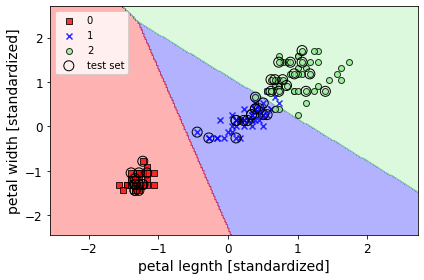

In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', multi_class='auto',
                        C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('petal legnth [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
save_fig('사이킷런의 로지스틱 회귀 모델이 만든 결정 경계')
plt.show()

훈련 샘플이 어떤 클래스에 속할 확률은 <code>predict_proba()</code> 메서드를 사용하여 계산한다. 예를 들어 테스트 세트에 있는 처음 세 개의 샘플 확률을 다음과 같이 예측할 수 있다.

In [34]:
lr.predict_proba(X_test_std[:4, :])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13],
       [4.99047943e-05, 6.42479627e-01, 3.57470468e-01]])

첫 번째 행은 첫 번째 붓꽃 샘플의 클래스 소속 확률이다. 두 번째 행은 두 번째 붓꽃 샘플의 클래스 소속 확률에 해당한다. 당연하지만 열을 모두 더하면 1이 된다.

In [35]:
(lr.predict_proba(X_test_std[:4, :])).sum(axis=1)

array([1., 1., 1., 1.])

첫 번째 행에서 가장 큰 값은 대략 0.855 정도이다. 첫 번째 샘플이 클래스 3(Iris-verginica)에 속할 확률이 85.5%라는 뜻이다. 행에서 가장 큰 값이 열의 예측 클래스 레이블이 된다. 예를 들어 넘파이 <code>argmax()</code> 함수를 사용하면 다음과 같이 쓴다. 출력된 클래스 인덱스는 다음과 같다(각각 Iris-verginica, Iris-setosa, Iris-setosa, Iris-versicolor에 해당한다).

In [36]:
lr.predict_proba(X_test_std[:4, :]).argmax(axis=1)

array([2, 0, 0, 1], dtype=int64)

조건부 확률로부터 얻은 클래스 레이블은 수동적인 방법이다. 직접 <code>predict()</code> 메서드를 호출하여 빠르게 확인할 수 있다.

In [37]:
lr.predict(X_test_std[:4, :])

array([2, 0, 0, 1])

마지막으로 샘플 하나의 클래스 레이블을 예측할 때 주의할 점이 있다. 사이킷런은 입력 데이터로 2차원 배열을 기대하므로 하나의 행을 2차원 포맷으로 먼저 변경해야 한다. 하나의 행을 2차원 배열로 변환하는 한 가지 방법은 넘파이 <code>reshape()</code> 메서드를 사용하여 새로운 차원을 추가하는 것이다.<sup><a id="a03" href="#p03">[3]</a></sup> 예를 들어 다음과 같다.

In [38]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 결정 경계

In [39]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(int) # Iris-Virginica면 1, 그렇지 않으면 0

In [40]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률을 계산해보겠다.

그림 저장: logistic_regression_plot


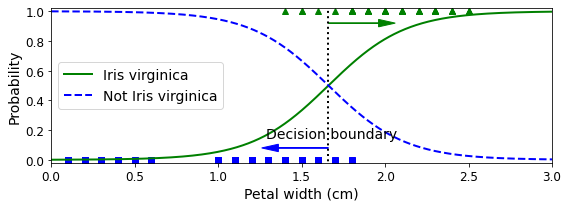

In [41]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

Iris-Verginica (삼각형으로 표시)의 꽃잎 너비는 1.4 ~ 2.5cm에 분포한다. 반면 다른 붓꽃(사각형으로 표시)은 일반적으로 꽃잎 너비가 더 작아 0.1 ~ 1.8cm에 분포한다. 그래서 약간 중첩되는 부분이 있다. 꽃잎 너비가 2cm 이상인 꽃은 분류기가 Iris-Verginica라고 강하게 확신한다(이 클래스에 대해 높은 확률을 출력한다). 반면 1cm 아래면 Iris-Verginica가 아니라고 강하게 확신한다('Not Iris verginica'클래스에 대한 확률이 높다). 이 두 극단 사이에서는 분류가 확실하지 않다. 하지만 어쨌든 클래스를 예측하려고 하면(<code>predict_proba()</code> 메서드 대신 <code>predict()</code> 메서드를 사용해서) 가장 가능성 높은 클래스를 반환할 것이다. 그렇기 때문에 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계<sup>decision boundary</sup>가 만들어진다. 꽃잎 너비가 1.6cm보다 크면 분류기는 Iris-Verginica로 분류하고, 그보다 작으면 아니라고 에측할 것이다(아주 확실하지 않더라도).

In [42]:
decision_boundary

array([1.66066066])

In [43]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

그림 저장: logistic_regression_contour_plot


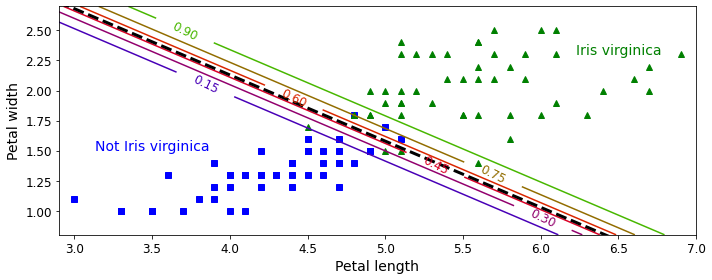

In [51]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

위 그림은 같은 데이터셋을 이번에는 꽃잎 너비와 꽃잎 길이 두 개의 특성으로 보여준다. 훈련이 끝나면 로지스틱 회귀 분류기가 이 두 특성을 기반으로 하여 새로운 꽃이 Iris-Verginica인지 확률을 추정할 수 있다. 점선은 모델이 50% 확률을 추정하는 지점으로, 이 모델의 결정 경계다. 이 경계는 선형임을 주목하자.<sup><a id="a04" href="#p04">[4]</a></sup> 15%(왼쪽 아래)부터 90%(오른쪽 위)까지 나란한 직선들은 모델이 특정 확률을 출력하는 포인트를 나타낸다. 모델은 맨 오른쪽 위의 직선을 넘어서 있는 꽃들을 90% 이상의 확률로 Iris-Virginica라고 판단할 것이다.

## 규제를 사용하여 과대적합 피하기

<b>규제화</b><sup>regularization</sup>는 공선성<sup>collinearity</sup>(특성 간의 높은 상관관계)을 다루거나 데이터에서 잡음을 제거하여 과대적합을 방지할 수 있는 매우 유용한 방법이다. 규제는 과도한 파라미터(가중치) 값을 제한하기 위해 추가적인 정보(편향)을 주입하는 개념이다.

이는 학습을 수행할 때 페널티를 부여하여 결정 경계를 매끄럽게 하는 작용을 한다. 입력 데이터에 대한 최적화를 할 때 규제항을 추가해주면 이미 노출된 학습 데이터의 영향을 과도하게 받지 않는다. 즉, 간단한 모델을 유지하도록 보정하는 역할이라고 보면 된다. 이런 방법으로 과적합을 억제하고 일반화 성능을 확보할 수 있다.

가장 널리 사용하는 규제 형태는 다음과 같은 L2 규제다(이따금 L2 축소 또는 가중치 감쇠라고 부른다).<sup><a id="05" href="#p05">[5]</a></sup> 이는 가중치 파라미터의 제곱을 손실 함수에 페널티로 더해준다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/L2 규제항.png">
</div>

이 식에서 λ는 규제 하이퍼파라미터다. 여기서 손실 함수를 최소화할 때 값이 너무 큰 가중치 파라미터에 페널티가 부여된다. λ의 값은 교차검증을 통해 결정한다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> 규제는 표준화 같은 특성 스케일 조정이 중요한 또 다른 이유다. 규제가 잘 동작하려면 모든 특성이 비슷한 스케일을 가져야 한다.
</div>

로지스틱 회귀의 비용 함수는 규제 항을 추가해서 규제를 적용한다. 규제 항은 모델 훈련 과정에서 가중치를 줄이는 역할을 한다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/L2 규제.png">
</div>

규제 하이퍼파라미터 λ를 사용하여 가중치를 작게 유지하면서 훈련 데이터에 얼마나 잘 맞출지를 조정할 수 있다. λ 값을 증가하면 규제 강도가 높아진다.

사이킷런의 LogisticRegression 클래스의 매개변수 C는 후에 소개할 서포트 벡터 머신 형식에서 따왔다. 매개변수 C는 규제 하이퍼파라미터 λ의 역수다. 결과적으로 역 규제 파라미터 C의 값을 감소시키면 규제 강도가 증가한다. 두 개의 가중치에 대해서 L2 규제 효과를 그래프로 나타내 보겠다.<sup><a id="a06" href="#p06">[6]</a></sup>

그림 저장: 규제 매개변수에 따른 가중치 크기의 변화


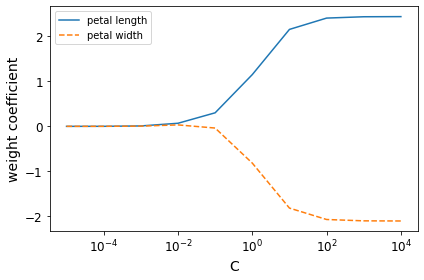

In [56]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c,
                            random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
save_fig('규제 매개변수에 따른 가중치 크기의 변화')
plt.show()

이 코드를 실행하면 역 규제 매개변수 C의 값을 바꾸면서 열 개의 로지스틱 회귀 모델을 훈련한다. 시연을 위해 모든 분류기에서 클래스 1의 가중치 값만 사용한다(여기서는 데이터셋에 있는 두 번째 클래스인 Iris-versicolor). 다중 분류에는 OvR 기법을 사용한다.

결과 그래프에서 볼 수 있듯이 매개변수 C가 감소하면 가중치 절댓값이 줄어든다. 즉, 규제 강도가 증가한다.

## 소프트맥스 회귀

로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다. 이를 <b>소프트맥스 회귀</b><sup>softmax regression</sup> 또는 <b>다항 로지스틱 회귀</b><sup>multinomial logistic regression</sup>라고 한다.

개념은 매우 간단하다. 샘플 <b>x</b>가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 <i>k</i>에 대한 점수 s<sub>k</sub>(<b>x</b>)를 계산하고, 그 점수에 <b>소프트맥스 함수</b><sup>softmax function</sup>(또는 <b>정규화된 지수 함수</b><sup>normalized exponential function</sup>라고 부른다)를 적용하여 각 클래스의 확률을 추정한다. s<sub>k</sub>(<b>x</b>)를 계산하는 식은 다음과 같다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/소프트맥스 점수.png">
</div>

각 클래스는 자신만의 파라미터 벡터 <b>θ</b><sup>(k)</sup>가 있다. 이 벡터들은 <b>파라미터 행렬</b><sup>parameter matrix</sup> <b>Θ</b>에 행으로 저장된다.<sup><a id="a07" href="#p07">[7]</a></sup>

샘플 <b>x</b>에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 <i>k</i>에 속할 확률 ^<i>p<sub>k</sub></i>을 추정할 수 있다. 이 함수는 각 점수에 지수 함수를 적용한 후 정규화한다(모든 지수 함수 결과의 합으로 나눈다). (사실 정규화되지 않은 로그-오즈이지만) 일반적으로 이 점수를 로짓 또는 로그-오즈라고 부른다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/소프트맥스 함수.png">
</div>

<ul>
    <li>K는 클래스 수다</li>
    <li><b>s(x)</b>는 샘플 <b>x</b>에 대한 각 클래스의 점수를 담은 벡터다</li>
    <li><b>σ(s(x))</b><sub>k</sub>는 샘플 <b>x</b>에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 <i>k</i>에 속할 추정 확률이다</li>
</ul>

로지스틱 회귀 분류기와 마탄가지로 소프트맥스 회귀 분류기는 다음 식처럼 추정 확률이 가장 높은 클래스(그냥 가장 높은 점수를 가진 클래스)를 선택한다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/소프트맥스 회귀 분류기의 예측.png">
</div>

<b>argmax</b> 연산은 함수를 최대화하는 변수의 값을 반환한다. 이 식에서는 추정 확률 <b>σ(s(x))</b><sub>k</sub>가 최대인 <i>k</i> 값을 반환한다.

<b>TIP</b> 소프트맥스 회귀 분류기는 한 번에 하나의 클래스만 예측한다(즉, 다중 클래스<sup>multiclass</sup>지 다중 출력<sup>multioutput</sup>은 아니다). 그래서 종류가 다른 붓꽃 같이 상호 배타적인 클래스에서만 사용해야 한다. 하나의 사진에서 여러 사람의 얼굴을 인식하는 데는 사용할 수 없다.

모델이 어떻게 확률을 추정하고 예측을 만드는지 알았으므로 훈련 방법에 대해 살펴보겠다. 모델이 타깃 클래스에 대해서는 높은 확률을(그리고 다른 클래스에 대해서는 낮은 확률을) 추정하도록 만드는 것이 목적이다. 다음 식의 <b>크로스 엔트로피</b><sup>cross entropy</sup> 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합하다. 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 추정하는 용도로 종종 사용된다.

<div style="text-align:center;">
    <img src="./images/formula/Logistic Regression/크로스 엔트로피 비용 함수.png">
</div>

<ul>
    <li>이 식에서 <i>y</i><sup>(i)</sup><sub>k</sub>는 <i>i</i>번째 샘플이 클래스 <i>k</i>에 속할 타깃 확률이다. 일반적으로 샘플이 클래스에 속하는지 아닌지에 따라 1 또는 0이 된다.</li>
</ul>

딱 두 개의 클래스가 있을 때(K = 2) 이 비용 함수는 로지스틱 회귀의 비용 함수와 같다.

<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>크로스 엔트로피</strong></div><br>
    크로스 엔트로피는 원래 정보 이론에서 유래했다. 매일 날씨 정보를 효율적으로 전달하려 한다고 가정하자. 8가지 정보(맑음, 비 등)가 있다면 2<sup>3</sup> = 8이므로 이 선택 사항을 3비트를 사용하여 인코딩할 수 있다. 그러나 거의 대부분의 날이 맑음이라면 '맑음'을 하나의 비트(0)로 인코딩하고 다른 일곱 개의 선택 사항을 (1로 시작하는) 4비트로 표현하는 것이 효율적이다. 크로스 엔트로피는 선택 사항마다 전송한 평균 비트 수를 측정한다. 날씨에 대한 가정이 완벽하면 크로스 엔트로피는 날씨 자체의 엔트로피와 동일할 것이다.(즉, 예측 불가능한 고유 성질이다). 하지만 이런 가정이 틀렸다면(즉, 비가 자주 온다면) 크로스 엔트로피는 <b>쿨백-라이블러 발산</b><sup>Kullback-Leibler divergence</sup>이라 불리는 양만큼 커질 것이다.<sup><a id="a08" href="#p08">[8]</a></sup><br><br>
    두 확률 분포 <i>p</i>와 <i>q</i> 사이의 크로스 엔트로피는 H(<i>p, q</i>) = - Σ<sub>x</sub><i>p(x)</i>log<i>q(x)</i>)로 정의한다(분포가 이산적일 때). 조금 더 자세한 내용은 다음 동영상을 참고하자(<a href='https://www.youtube.com/watch?v=ErfnhcEV1O8' target='blank'>https://www.youtube.com/watch?v=ErfnhcEV1O8</a>).
</div>

좀 더 자세한 내용은 <a href="https://datascienceschool.net/03%20machine%20learning/10.01%20%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1%20%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D.html" target="blank">데이터 사이언스 스쿨</a> 또는 <a href="https://ko.wikipedia.org/wiki/%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1_%ED%9A%8C%EA%B7%80" target="blank">위키피디아: 로지스틱 회귀</a>를 참고하자.

# 미주

<b id="p01">1</b> 시그모이드<sup>sigmoid</sup>란 'S자 모양'이라는 뜻이다. 계단 함수처럼 그 모양을 따 이름을 지은 것이다. [↩](#a01)

<b id="p02">2</b> Π 기호는 수열의 곱을 나타낸다. 여기서는 n개의 샘플이 해당 클래스에 속할 확률을 곱한 것이다. 양성 샘플일 경우 1-<i>y<sup>(i)</sup></i>가 0이 되어 두 번째 항이 1이 되고 양성 샘플일 확률 <i>Φ(z<sup>(i)</sup>)</i>만 남는다. 반대로 음성 샘플일 경우 <i>y<sup>(i)</sup></i>가 0이 되어 첫 번째 항이 1이 되고 음성 샘플일 확률 1 - <i>Φ(z<sup>(i)</sup>)</i>만 남는다. 따라서 가능도가 최대가 되려면 양성 샘플의 <i>Φ(z<sup>(i)</sup>)</i>는 가능한 크고 음성 샘플의 <i>Φ(z<sup>(i)</sup>)</i>는 가능한 작아야 한다. [↩](#a02)

<b id="p03">3</b> 다른 방법으로는 <code>np.expand_dims(X_test_std[0, :], axis=0)</code>처럼 사용할 수 있다. 또는, <code>X_test_std[0, np.newaxis]</code>처럼 사용할 수도 있다. 가장 간단한 방법은 <code>X_test_std[0:1, :]</code>처럼 인덱스 슬라이싱을 사용하는 것이다. [↩](#a03)

<b id="p04">4</b> 이 경계는 직선 방정식 <i>Θ<sub>0</sub> + Θ<sub>1</sub>x<sub>1</sub> + Θ<sub>2</sub>x<sub>2</sub></i> = 0을 만족하는 포인트 <b>x</b>의 집합이다. [↩](#a04)

<b id="p05">5</b> L2 규제에 사용하는 식은 L2 노름의 제곱이지만 보통 L2 규제라고 한다. [↩](#a05)

<b id="p06">6</b> LogisticRegression의 penalty 매개변수의 기본값이 L2 규제를 의미하는 'l2'이며 'l1'으로 바꾸어 L1 규제를 사용할 수도 있다. 매개변수 C의 기본값은 1.0이다. [↩](#a06)

<b id="p07">7</b> LogisticRegression 모델의 coef_ 속성은 (클래스 수, 특성 수) 크기의 2차원 배열이다. intercept_ 속성은 클래스 수와 크기가 같은 1차원 배열이다. [↩](#a07)

<b id="p08">8</b> 맑음은 1비트, 다른 날씨는 4비트로 전송된다고 하고 맑은 날의 비율이 80%라면 평균 전송 비트 수는 1.6이 된다. 하지만 맑은 날의 비율이 50%라면 평균 전송 비트 수는 2.5로 늘어난다. 이 두 엔트로피의 차이가 이상적인 확률 분포와 이에 근사하는 확률 분포 사이의 차이를 나타내는 쿨백-라이블러 발산이다. 이와 비슷한 예가 구글 브레인 팀의 머신러닝 연구원인 크리스토퍼 올라(Christopher Olah)의 블로그에 자세하게 나와 있다(<a href='https://colah.github.io/posts/2015-09-Visual-Information/' target='blank'>https://colah.github.io/posts/2015-09-Visual-Information/</a>). [↩](#a08)